# Assignment 3 -  Project (ML part)

## 1. Preprocessing

## 1.1. Import necessary Libraries

In [4]:
# Importing necessary libraries
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.preprocessing import OneHotEncoder
from skimage.feature import hog
from skimage import color
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

## 1.2. Load CIFAR10 Dataset

In [5]:
# Listing the dataset directory
dataset_dir = "./dataset"
files = os.listdir(dataset_dir)
print(files)

['batches.meta', 'data_batch_1', 'data_batch_2', 'data_batch_3', 'data_batch_4', 'data_batch_5', 'readme.html', 'test_batch']


In [7]:
# Function to unpickle dataset files
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Identifying train and test batches
train_batches = [f"data_batch_{i}" for i in range(1, 6)]
test_batch = "test_batch"


# 1.3. Load and Combine Training Batches

In [8]:
# Function to load a batch
def load_batch(file):
    data = unpickle(file)
    X = data[b'data']
    Y = data[b'labels']
    return X, Y

# Loading and combining all training batches
images, labels = [], []
for batch in train_batches:
    X, Y = load_batch(os.path.join(dataset_dir, batch))
    images.extend(X)
    labels.extend(Y)

# Converting to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Printing the shapes to verify
print(f"Images shape: {images.shape}")
print(f"Labels shape: {labels.shape}")


Images shape: (50000, 3072)
Labels shape: (50000,)


## 1.4. Normalize the Images

In [9]:
# Normalize the images to have pixel values between 0 and 1
images = images / 255.0

# Printing the shape to verify
print(f"Normalized images shape: {images.shape}")


Normalized images shape: (50000, 3072)


## 1.5. One-Hot Encode the labels

In [10]:
# One hot encode the labels
one_hot_encoder = OneHotEncoder()
labels = one_hot_encoder.fit_transform(labels.reshape(-1, 1)).toarray()

# Printing the shape to verify
print(f"One-hot encoded labels shape: {labels.shape}")


One-hot encoded labels shape: (50000, 10)


## 2. Exploratory Data Analysis (EDA)

### 2.1. View random Images from Each Class

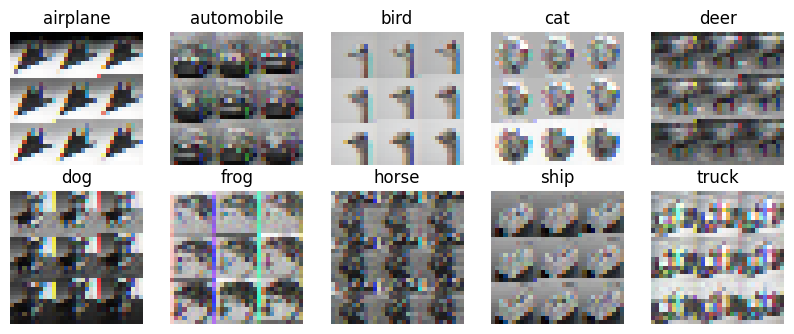

In [11]:
# Define the class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Function to display random images from each class
def display_random_images(images, labels, class_names):
    plt.figure(figsize=(10, 10))
    for i in range(len(class_names)):
        # Select random images for each class
        idx = np.where(labels == i)[0]
        img = images[idx[np.random.randint(len(idx))]]
        img = img.reshape(32, 32, 3)
        plt.subplot(5, 5, i + 1)
        plt.imshow(img)
        plt.title(class_names[i])
        plt.axis('off')
    plt.show()

# Convert labels back to integers for visualization
int_labels = labels.argmax(axis=1)

# Display random images from each class
display_random_images(images, int_labels, class_names)


### 2.2. Class Distribution Visualization

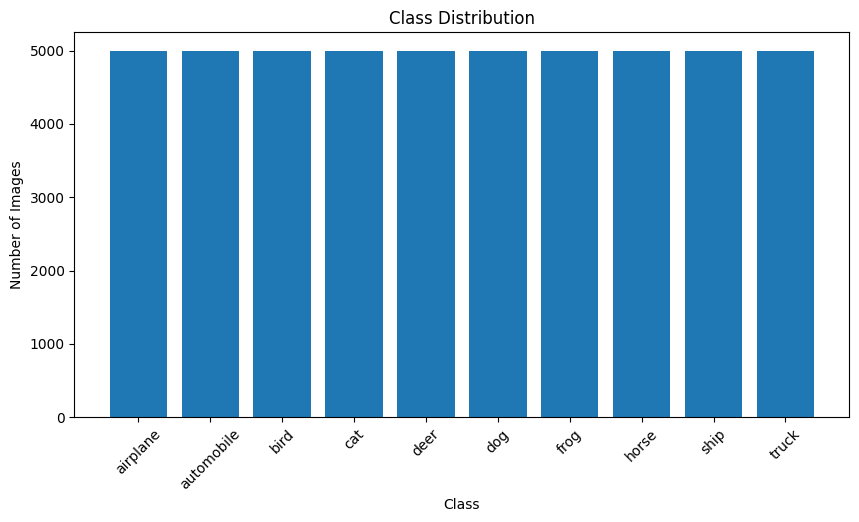

In [12]:
# Visualize the class distribution

# Count the number of images in each class
class_distribution = Counter(int_labels)

# Plot the class distribution
plt.figure(figsize=(10, 5))
plt.bar(class_distribution.keys(), class_distribution.values())
plt.xticks(ticks=range(len(class_names)), labels=class_names, rotation=45)
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Class Distribution')
plt.show()


# 3. Formulate the Problem

## 3.1. Define the Image Classification Task

The problem we are addressing is a multi-class image classification task where we aim to classify images into one of the 10 classes provided in the CIFAR10 dataset. The goal is to develop a machine learning model that can accurately predict the class of a given image based on the features extracted from the images.

## 3.2. Choosen suitable Machine Learing Algorithm

For this task, we will choose a traditional machine learning algorithm. Some suitable options include:

- Support Vector Machines (SVM)
- Random Forests
- k-Nearest Neighbors (k-NN)

We choose to proceed with SVM due to following reasong:

1. SVM is effective in high-dimensional spaces, which is beneficial for image classification tasks where the input data has many features.
2. SVM is versatile and can be used for both linear and non-linear classification through the use of different kernel functions.
3. SVM has been proven to be robust and performs well in various classification tasks, making it a reliable choice for our problem.


## 4. Data Partitioning

### 4.1. Load the Training and Test Batches

In [13]:
 #Load the test batch
test_images, test_labels = load_batch(os.path.join(dataset_dir, test_batch))

# Convert to numpy arrays
test_images = np.array(test_images)
test_labels = np.array(test_labels)

# Normalize the test images
test_images = test_images / 255.0

# One-hot encode the test labels
test_labels = one_hot_encoder.transform(test_labels.reshape(-1, 1)).toarray()

# Print the shapes to verify
print(f"Test images shape: {test_images.shape}")
print(f"Test labels shape: {test_labels.shape}")

Test images shape: (10000, 3072)
Test labels shape: (10000, 10)


### 4.2. Verify the Data Splits

In [14]:
# Verify the number of samples in training and test sets
print(f"Number of training samples: {images.shape[0]}")
print(f"Number of test samples: {test_images.shape[0]}")


Number of training samples: 50000
Number of test samples: 10000


## 5. Feature Engineering

### 5.1. Extract HOG Features for Images

In [8]:
!pip install scikit-image

In [9]:
# Function to extract HOG features
def extract_hog_features(images):
    hog_features = []
    for image in images:
        # Reshape and convert the image to grayscale
        image = image.reshape(32, 32, 3)
        gray_image = color.rgb2gray(image)
        # Extract HOG features
        features = hog(gray_image, pixels_per_cell=(8, 8), cells_per_block=(2, 2))
        hog_features.append(features)
    return np.array(hog_features)

# Extract HOG features from training images
x_train_hog = extract_hog_features(images)
# Extract HOG features from test images
x_test_hog = extract_hog_features(test_images)

# Print the shape of the HOG feature arrays to verify
print(f"HOG features shape (train): {x_train_hog.shape}")
print(f"HOG features shape (test): {x_test_hog.shape}")


HOG features shape (train): (50000, 324)
HOG features shape (test): (10000, 324)


## 5. Model Development

### 5.1. Train the SVM Model

In [10]:
# Define the SVM model
svm_model = SVC()

# Train the SVM model on the HOG features
svm_model.fit(x_train_hog, labels.argmax(axis=1))  # Use integer labels


SVC()

### 5.2. Hyperparameter Tuning

In [11]:
# Define the parameter grid for hyperparameter tuning
param_grid = {'C': [0.1, 1, 10], 'gamma': [1, 0.1, 0.01]}

# Initialize GridSearchCV with the SVM model and parameter grid
grid_search = GridSearchCV(svm_model, param_grid, cv=3)

# Fit GridSearchCV to the training data
grid_search.fit(x_train_hog, labels.argmax(axis=1))  # Use integer labels

# Get the best estimator (model) from the grid search
best_model = grid_search.best_estimator_


### 5.3. Evaluate the Model

In [13]:
!pip install seaborn

   ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
   ------------------------------------ --- 266.2/294.9 kB 8.3 MB/s eta 0:00:01
   ---------------------------------------- 294.9/294.9 kB 4.6 MB/s eta 0:00:00


In [16]:
import seaborn as sns

# Predict the labels for the test set
y_pred = best_model.predict(x_test_hog)


print("success")

hello


Test Accuracy: 0.3897


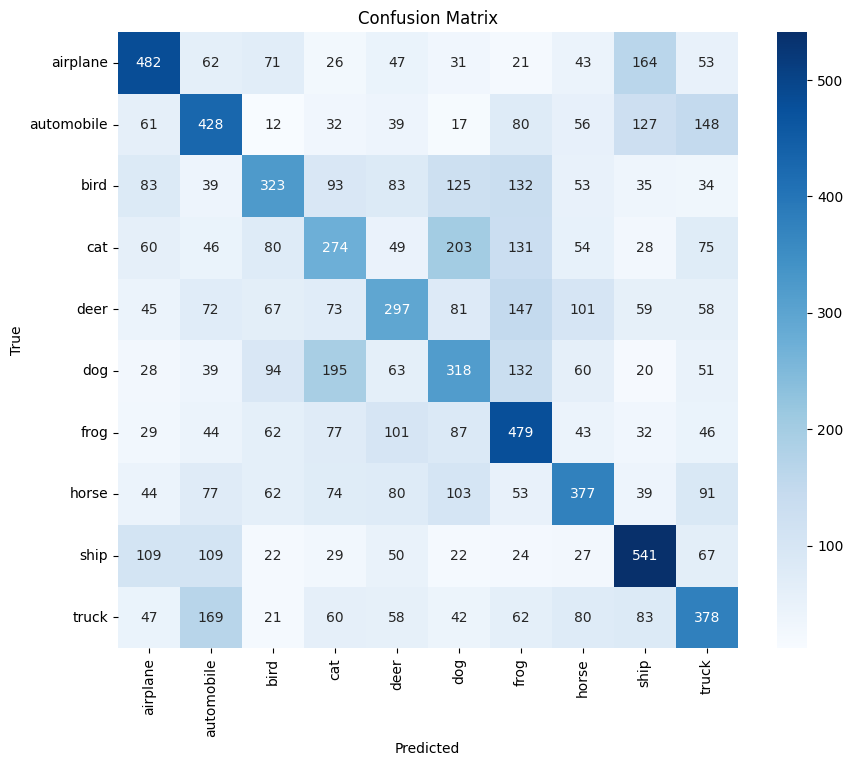

              precision    recall  f1-score   support

    airplane       0.49      0.48      0.48      1000
  automobile       0.39      0.43      0.41      1000
        bird       0.40      0.32      0.36      1000
         cat       0.29      0.27      0.28      1000
        deer       0.34      0.30      0.32      1000
         dog       0.31      0.32      0.31      1000
        frog       0.38      0.48      0.42      1000
       horse       0.42      0.38      0.40      1000
        ship       0.48      0.54      0.51      1000
       truck       0.38      0.38      0.38      1000

    accuracy                           0.39     10000
   macro avg       0.39      0.39      0.39     10000
weighted avg       0.39      0.39      0.39     10000



In [19]:
# Define the class names and label_class_map
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
label_class_map = {i: class_names[i] for i in range(len(class_names))}

# Calculate the accuracy
accuracy = accuracy_score(test_labels.argmax(axis=1), y_pred)
print(f"Test Accuracy: {accuracy}")

# Generate the confusion matrix
conf_matrix = confusion_matrix(test_labels.argmax(axis=1), y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_class_map.values(), yticklabels=label_class_map.values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(test_labels.argmax(axis=1), y_pred, target_names=class_names))
